In [1]:
#Voglio backtestare la strategia con parametri multipli e vedere come si comporta. Devo applicare la funzione di backtest
#e poi fare un plot dei risultati in 3d.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb


#FROM JANUARY 2024 TO AUGUST 2024
data = pd.read_csv(r'C:\Users\camere\Conda_3.11_enviroment\CSV DATA\1min data\eurgbp-m1-bid-2024-01-01-2024-08-22.csv',
                   index_col=0, parse_dates=True)

close_price = data['close'].to_numpy()
print(close_price) #now i got a numpy array with the closing prices of the currency pair;


[0.86692 0.86722 0.86723 ... 0.85203 0.85207 0.852  ]


In [2]:
#Now I need to implement a Take Profit and Stop Loss in % points inside this backtest function.
#Create a backtesting function that backtests based on Bollinger Bands
import numpy as np
from numba import njit #We import the njit decorator from the numba library
@njit(fastmath=True) #We use the njit decorator to compile the function to machine code, which makes it faster
def backtest_bollinger_bands(data, window, num_std_devs, fees_percentage=0.015, starting_cash=10000, stop_loss_percentage=0.01):
    
    
    #-------------------Bollinger Bands-------------------

    #We calculate the rolling mean:
    middle_band = np.zeros(len(data)) #We create an array of zeros to store the rolling mean
    for i in range(window, len(data)):
        middle_band[i] = np.mean(data[i-window:i]) #We calculate the rolling mean for each day

    #We calculate the rolling standard deviation:
    rolling_std = np.zeros(len(data))
    for i in range(window, len(data)):
        rolling_std[i] = np.std(data[i-window:i]) #We calculate the rolling standard deviation for each day

    #We calculate the upper and lower bands:
    upper_band = middle_band + num_std_devs * rolling_std
    lower_band = middle_band - num_std_devs * rolling_std


    

    #Strategy's logic:
    positions = np.zeros(len(data)) #We create an array of zeros to store the positions
    entry_price = 0.0 # Variable to track the entry price of the position
    stop_loss_triggered = False # Flag to track if stop loss was triggered
    
    for i in range(window, len(data)): # from the second row to the last row of the data
        # Reset stop loss flag if price moves back across bands
        if stop_loss_triggered: #chekcs if the stop loss was triggered (boolean)
            if positions[i-1] >= 0 and data[i] > lower_band[i]:  # For long positions
                stop_loss_triggered = False
            elif positions[i-1] <= 0 and data[i] < upper_band[i]:  # For short positions
                stop_loss_triggered = False
        
        # Entry conditions - only if stop loss not triggered
        if data[i] < lower_band[i] and positions[i-1] == 0 and not stop_loss_triggered:
            positions[i] = 1 # long if the price is below the lower band
            entry_price = data[i] # Record the entry price
        elif data[i] > upper_band[i] and positions[i-1] == 0 and not stop_loss_triggered:
            positions[i] = -1 # short if the price is above the upper band
            entry_price = data[i] # Record the entry price
        # Exit conditions
        elif data[i] > middle_band[i] and positions[i-1] == 1:
            positions[i] = 0 # close long position
        elif data[i] < middle_band[i] and positions[i-1] == -1:
            positions[i] = 0 # close short position
        # Stop loss conditions
        elif positions[i-1] == 1 and data[i] < entry_price * (1 - stop_loss_percentage):
            positions[i] = 0 # close long position
            stop_loss_triggered = True # Set stop loss flag
        elif positions[i-1] == -1 and data[i] > entry_price * (1 + stop_loss_percentage):
            positions[i] = 0 # close short position
            stop_loss_triggered = True # Set stop loss flag
        else:
            positions[i] = positions[i-1] # maintain previous position



    #We calculate the returns of the strategy:
    
    market_returns = np.zeros(len(data)) #We create an array of zeros to store the market returns
    for i in range(1, len(data)):
        market_returns[i] = (data[i] - data[i-1]) / data[i-1] #We calculate the market returns for each day
    
    strategy_returns = np.zeros(len(data)) #We create an array of zeros to store the strategy returns
    for i in range(1, len(data)):
        strategy_returns[i] = positions[i-1] * market_returns[i] #We calculate the strategy returns for each day, shifting the positions array by 1 day
    

    #Calculate equity with for loop
    equity = np.zeros(len(data))
    equity[0] = starting_cash

    for i in range(1, len(data)):
        if positions[i-1] == positions[i]:
            equity[i] = equity[i-1] * (1 + strategy_returns[i])
        else:
            equity[i] = equity[i-1] * (1 + strategy_returns[i]) - equity[i-1] * fees_percentage / 100


    return equity

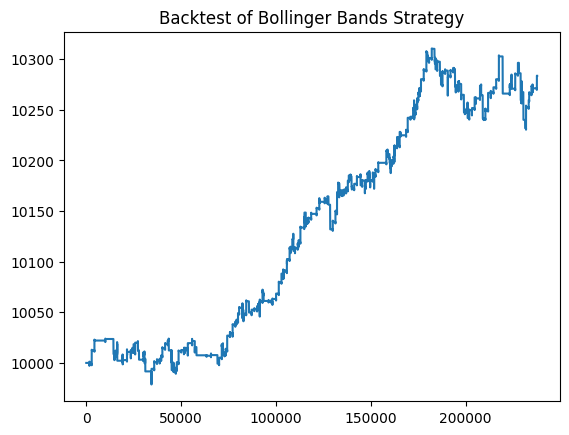

10283.552174428714


In [14]:
backtest1 = backtest_bollinger_bands(data=close_price, window=120, num_std_devs=5, fees_percentage=0.015, starting_cash=10000, stop_loss_percentage=0.0005)

plt.plot(backtest1)
plt.title('Backtest of Bollinger Bands Strategy')
plt.show()
print(backtest1[-1]) #print the final equity of the strategy

### Stop Loss Flag Mechanism

The `stop_loss_triggered` flag is a crucial safety mechanism that prevents immediate re-entry after a stop loss:

1. **Initial State**: Flag starts as `False`, allowing normal trading
2. **When Stop Loss Hits**: 
   - Position is closed
   - Flag set to `True`
   - Prevents new entries while `True`
3. **Reset Conditions**:
   - For long positions: Flag resets when price moves above lower band
   - For short positions: Flag resets when price moves below upper band

This prevents the "loop trap" where a strategy would immediately re-enter after stop loss, potentially causing repeated losses.

In [ ]:
# Example of stop loss flag behavior
def example_stop_loss_sequence(price, lower_band, upper_band):
    stop_loss_triggered = False
    position = "None"
    
    if price < lower_band and not stop_loss_triggered:
        position = "Long"  # Enter long
    
    if position == "Long" and stop_loss_hit:
        position = "None"
        stop_loss_triggered = True  # Prevent re-entry
        
    # Only reset flag when price moves back above band
    if stop_loss_triggered and price > lower_band:
        stop_loss_triggered = False  # Now safe to enter again